# Stop words

In [1]:
import re
import csv
import json
import operator
import numpy as np
from watson_developer_cloud import NaturalLanguageClassifierV1

dataset is a random sample from IBM's GitHub repositories. the dataset is split into training and testing set equally in order to induce high variance, which will then be reduced by removing stop words 

In [2]:
data = np.load("data.npz",encoding='latin1')
data = data.f.arr_0

In [3]:
trainingdata = data[0:100]
testdata = data[100:200]

In [52]:
def buildstoplist():
    index = {}
    wordcount = 0
    wordprob = {}
    stopwords = []
    for i in trainingdata:
        for word in i[0].split():
            word = re.sub('[^a-zA-Z0-9 \n\.]', '', word)
            if word != '':
                wordcount += 1
                if word not in index:
                    index[word] = 1
                else:
                    index[word] += 1
    
    for word in index.iterkeys():
        wordprob[word] = round(float(index[word])/wordcount*100,4)
        
    stoplist = sorted(wordprob.iteritems(), key=operator.itemgetter(1) ,reverse=True)[:10]
    
    for i in stoplist:
        stopwords.append(i[0])
    
    #stoplist contains tuples of the stop words ranked by the percentage of total word occurances
    #stopwords is a list of these words
    return stoplist, stopwords

In [53]:
stoplist,stopwords = buildstoplist()

In [29]:
stoplist

[('the', 3.3051),
 ('return', 1.4292),
 ('if', 1.2332),
 ('to', 1.2201),
 ('import', 1.147),
 ('for', 1.0346),
 ('public', 0.9928),
 ('a', 0.8727),
 ('is', 0.776),
 ('in', 0.7499)]

In [30]:
stopwords

['the', 'return', 'if', 'to', 'import', 'for', 'public', 'a', 'is', 'in']

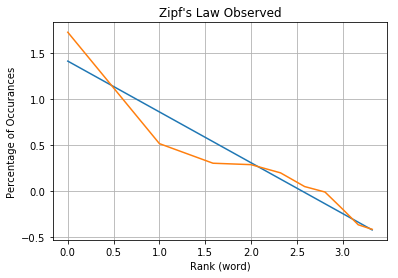

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting, translating ranks and percentages to a log-log plot
t = np.array([np.log2(1), np.log2(2), np.log2(3),np.log2(4),np.log2(5),np.log2(6),np.log2(7),np.log2(8),np.log2(9),np.log2(10)])
s = np.array([np.log2(3.3051), np.log2(1.4292), np.log2(1.2332), np.log2(1.2201), np.log2(1.147), np.log2(1.0346), np.log2(.9928), np.log2(.8727), np.log2(.776), np.log2(.7499)])


#adding a best fit line so the linearity of the log-log plot can be observed
fig, ax = plt.subplots()
m, b = np.polyfit(t, s, 1)
ax.plot(t, m*t + b, '-')
ax.plot(t, s)

ax.set(xlabel='Rank (word)', ylabel='Percentage of Occurances',
       title="Zipf's Law Observed")
ax.grid()

fig.savefig("test.png")
plt.show()



In [8]:
def removestopwords(line, stoplist):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    return pattern.sub('', line)

In [31]:
chunk = 1024

with open('stopwords.csv', 'w') as csvfile:
    fieldnames = ['text', 'pl']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for i in trainingdata:
        for j in range(0,len(i[0]),chunk):
            text = re.sub(' +',' '," ".join(re.split(r'[^\w]', re.sub(re.compile("/\*.*?\*/",re.DOTALL ) ,"" ,i[0][j:j+chunk]))))   
            if text == '':
                continue
            else:
                writer.writerow({'text': text, 'pl': i[1]})
                
with open('nostopwords.csv', 'w') as csvfile:
    fieldnames = ['text', 'pl']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for i in trainingdata:
        #below is the extra line used to remove stop words
        processedtext = removestopwords(i[0],stopwords)
        for j in range(0,len(processedtext),chunk):
            text = re.sub(' +',' '," ".join(re.split(r'[^\w]', re.sub(re.compile("/\*.*?\*/",re.DOTALL ) ,"" ,processedtext[j:j+chunk]))))   
            if text == '':
                continue
            else:
                writer.writerow({'text': text, 'pl': i[1]})

Get a username and password for Watson Natural Language Classifier at IBM Cloud
https://console.bluemix.net/catalog/services/natural-language-classifier

In [32]:
username="USERNAME"
password="PASSWORD"

classifier_id = "CLASSIFIER ID"
natural_language_classifier = NaturalLanguageClassifierV1(
    username=username,
    password=password)

In [44]:
with open('stopwords.csv', 'rb') as stopwords:
    print(json.dumps(natural_language_classifier.create(training_data=stopwords, name='stopwords'), indent=2))

with open('nostopwords.csv', 'rb') as nostopwords:
    print(json.dumps(natural_language_classifier.create(training_data=nostopwords, name='nostopwords'), indent=2))

{
  "status": "Training", 
  "name": "stopwords", 
  "language": "en", 
  "created": "2018-03-05T05:45:28.297Z", 
  "url": "https://gateway.watsonplatform.net/natural-language-classifier/api/v1/classifiers/8fc31cx297-nlc-3731", 
  "status_description": "The classifier instance is in its training phase, not yet ready to accept classify requests", 
  "classifier_id": "8fc31cx297-nlc-3731"
}
{
  "status": "Training", 
  "name": "nostopwords", 
  "language": "en", 
  "created": "2018-03-05T05:45:30.455Z", 
  "url": "https://gateway.watsonplatform.net/natural-language-classifier/api/v1/classifiers/8fc4f0x298-nlc-3911", 
  "status_description": "The classifier instance is in its training phase, not yet ready to accept classify requests", 
  "classifier_id": "8fc4f0x298-nlc-3911"
}


In [72]:
stopwordsclassifier = "8fc31cx297-nlc-3731"
nostopwordsclassifier = "8fc4f0x298-nlc-3911"

In [46]:
natural_language_classifier.status("8fc4f0x298-nlc-3911")

{u'classifier_id': u'8fc4f0x298-nlc-3911',
 u'created': u'2018-03-05T05:45:30.455Z',
 u'language': u'en',
 u'name': u'nostopwords',
 u'status': u'Training',
 u'status_description': u'The classifier instance is in its training phase, not yet ready to accept classify requests',
 u'url': u'https://gateway.watsonplatform.net/natural-language-classifier/api/v1/classifiers/8fc4f0x298-nlc-3911'}

In [47]:
natural_language_classifier.status("8fc4f0x298-nlc-3911")

{u'classifier_id': u'8fc4f0x298-nlc-3911',
 u'created': u'2018-03-05T05:45:30.455Z',
 u'language': u'en',
 u'name': u'nostopwords',
 u'status': u'Available',
 u'status_description': u'The classifier instance is now available and is ready to take classifier requests.',
 u'url': u'https://gateway.watsonplatform.net/natural-language-classifier/api/v1/classifiers/8fc4f0x298-nlc-3911'}

In [24]:
def compute_watson_accuracy(testdata, classifier_id):
    count = 0
    for i in testdata:
        x = natural_language_classifier.classify(classifier_id,re.sub(' +',' '," ".join(re.split(r'[^\w]', re.sub(re.compile("/\*.*?\*/",re.DOTALL ) ,"" ,i[0]))))[0:1024])
        if x['top_class'] == i[1]:
            count += 1
    return float(count)/len(testdata)

In [48]:
acc1 = compute_watson_accuracy(testdata,stopwordsclassifier)
acc2 = compute_watson_accuracy(testdata, nostopwordclassifier)

In [49]:
print acc1, acc2

0.85 0.86


In [50]:
!ls -al *csv

-rw-r--r--@ 1 nickacosta  staff  313102 Mar  4 23:42 nostopwords.csv
-rw-r--r--@ 1 nickacosta  staff  333678 Mar  4 23:39 stopwords.csv
